In [2]:
from constants import *
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm

In [3]:
# seed for reproducability
np.random.seed(42)
scipy.random.seed(42)
N = 10_000
z_80 = 1.28

In [4]:
expert_mean = 420
expert_sd = 153
expert_dist = scipy.stats.norm(expert_mean, expert_sd)

In [5]:
# simulate draws and approximate 80% CI
data = []
for i in trange(N):
    data.append(expert_dist.rvs(size=1)[0])

lwr, upr = scipy.stats.scoreatpercentile(data, 10), \
            scipy.stats.scoreatpercentile(data, 90)
pt_estimate = np.mean(data)

  0%|          | 0/10000 [00:00<?, ?it/s]

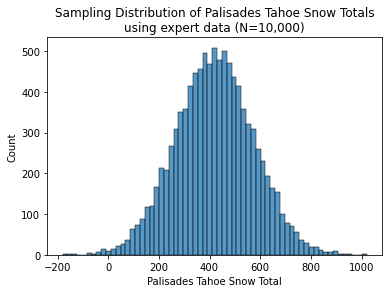

In [6]:
# visualize sample
fig, ax = plt.subplots()
# ax.scatter([lwr, upr], [0, 0], s=1000,marker="^", c="red")
sns.histplot(data, ax=ax);
ax.set_xlabel("Palisades Tahoe Snow Total")
ax.set_title("Sampling Distribution of Palisades Tahoe Snow Totals\nusing expert data (N=10,000)");
plt.savefig(os.path.join(IMG_PATH, "expert_distribution"))

In [25]:
analytical_expert_lwr, analytical_expert_upr = expert_mean - (z_80 * expert_sd), \
                                    expert_mean + ( z_80 * expert_sd)
print(f"Simulated solution: [{lwr}, {upr}]")
print(f"Analytical solution: [{analytical_expert_lwr, analytical_expert_upr}]")

Simulated solution: [128.91204890433204, 753.7122331373517]
Analytical solution: [(224.16, 615.84)]


In [8]:
# read yearly expert data
data = pd.read_csv(os.path.join(DATA_PATH, "expert_yearly.csv"))['Amount'].astype(int)

In [9]:
# helper moving average function
# @source: https://www.delftstack.com/howto/python/moving-average-python/
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

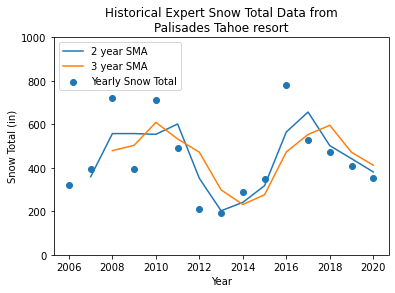

In [11]:
# display snow trend, along with 2 year and 3 year SMA
fig, ax = plt.subplots()
ax.scatter(np.arange(2006, 2021), data, label="Yearly Snow Total")
ax.plot(np.arange(2007, 2021), moving_average(data, 2), label="2 year SMA")
ax.plot(np.arange(2008, 2021), moving_average(data, 3), label="3 year SMA")
ax.set_ylim((0, 1000))
ax.set_xlabel("Year")
ax.set_ylabel("Snow Total (in)")
ax.set_title("Historical Expert Snow Total Data from\nPalisades Tahoe resort")
ax.legend();
plt.savefig(os.path.join(IMG_PATH, "expert_data_time_series"))

In [12]:
# read yearly on the snow data
df = pd.read_csv(os.path.join(DATA_PATH, "target_yearly.csv"))
data = df['Amount'].astype(int)

In [13]:
# calculate mean and sample SD
target_mean, target_sd = scipy.stats.norm.fit(data)
target_dist = scipy.stats.norm(target_mean, target_sd)
print(f"Found avg snow total of {target_mean} and sd of {target_sd}")

Found avg snow total of 375.44444444444446 and sd of 183.77529220407013


In [14]:
# simulate draws and calculate 80% CI
sample = []
for i in trange(N):
    sample.append(target_dist.rvs(size=1)[0])

lwr, upr = scipy.stats.scoreatpercentile(sample, 10), \
            scipy.stats.scoreatpercentile(sample, 90)
pt_estimate = np.mean(sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

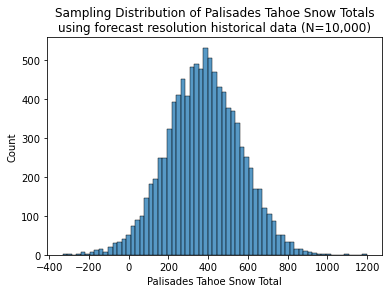

In [15]:
# visualize sample
fig, ax = plt.subplots()
# ax.scatter([lwr, upr], [0, 0], s=1000,marker="^", c="red")
sns.histplot(sample, ax=ax);
ax.set_xlabel("Palisades Tahoe Snow Total")
ax.set_title("Sampling Distribution of Palisades Tahoe Snow Totals\nusing forecast "
             "resolution historical data (N=10,000)");
plt.savefig(os.path.join(IMG_PATH, "onthesnow_distribution"))

In [26]:
analytical_yearly_lwr, analytical_yearly_upr = target_mean - (z_80 * target_sd), \
                                    target_mean + ( z_80 * target_sd)
print(f"Simulated solution: [{lwr}, {upr}]")
print(f"Analytical solution: [{analytical_yearly_lwr, analytical_yearly_upr}]")

Simulated solution: [128.91204890433204, 753.7122331373517]
Analytical solution: [(140.21207042323468, 610.6768184656543)]


In [17]:
## ENSO analysis
def fit_normal(dataset, condition):
    data = dataset[dataset['ENSO'] == condition]['Amount'].astype(int).values
    return scipy.stats.norm.fit(data)

nino_mean, nino_sd = fit_normal(df, 'El Nino')
nino_dist = scipy.stats.norm(nino_mean, nino_sd)
nina_mean, nina_sd = fit_normal(df, 'La Nina')
nina_dist = scipy.stats.norm(nina_mean, nina_sd)
neutral_mean, neutral_sd = fit_normal(df, 'Neutral')
neutral_dist = scipy.stats.norm(neutral_mean, neutral_sd)

In [18]:
sample = []
for i in trange(N):
    tup = (
        nino_dist.rvs(size=1)[0],
        nina_dist.rvs(size=1)[0],
        neutral_dist.rvs(size=1)[0]
    )
    sample.append(tup)

  0%|          | 0/10000 [00:00<?, ?it/s]

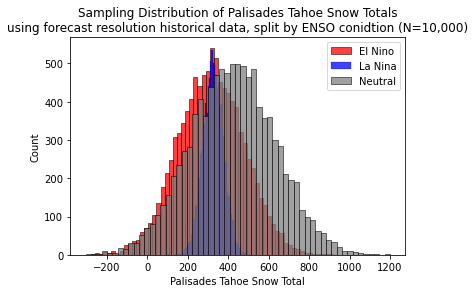

In [19]:
# visualize sample
fig, ax = plt.subplots()
# ax.scatter([lwr, upr], [0, 0], s=1000,marker="^", c="red")
sns.histplot([s[0] for s in sample], ax=ax, label="El Nino", color="Red");
sns.histplot([s[1] for s in sample], ax=ax, label="La Nina", color="Blue");
sns.histplot([s[2] for s in sample], ax=ax, label="Neutral", color="Grey");
ax.legend()
ax.set_xlabel("Palisades Tahoe Snow Total")
ax.set_title("Sampling Distribution of Palisades Tahoe Snow Totals\nusing forecast "
             "resolution historical data, split by ENSO conidtion (N=10,000)");
plt.savefig(os.path.join(IMG_PATH, "nino_onthesnow_distributions"))

In [20]:
# read monthly data
monthly_df = pd.read_csv(os.path.join(DATA_PATH, "monthly_data.csv"))

In [21]:
# get three distributions
## ENSO analysis
# import ipdb
def fit_normal(dataset, section):
    # ipdb.set_trace()
    data = dataset[dataset['Section'] == section]['Amount'].astype(int).values
    return scipy.stats.norm.fit(data)

early_mean, early_sd = fit_normal(monthly_df, 'Early')
early_dist = scipy.stats.norm(early_mean, early_sd)
mid_mean, mid_sd = fit_normal(monthly_df, 'Mid')
mid_dist = scipy.stats.norm(mid_mean, mid_sd)
late_mean, late_sd = fit_normal(monthly_df, 'Late')
late_dist = scipy.stats.norm(late_mean, late_sd)

In [22]:
sample = []
for i in trange(N):
    tup = (
        early_dist.rvs(size=1)[0],
        mid_dist.rvs(size=1)[0],
        late_dist.rvs(size=1)[0]
    )
    sample.append(tup)

  0%|          | 0/10000 [00:00<?, ?it/s]

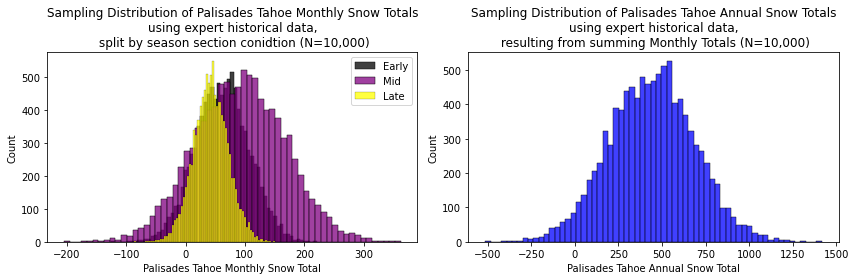

In [23]:
# visualize sample
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax.scatter([lwr, upr], [0, 0], s=1000,marker="^", c="red")
sns.histplot([s[0] for s in sample], label="Early", color="Black", ax=ax[0]);
sns.histplot([s[1] for s in sample], label="Mid", color="Purple", ax=ax[0]);
sns.histplot([s[2] for s in sample], label="Late", color="Yellow", ax=ax[0]);
ax[0].legend()
ax[0].set_xlabel("Palisades Tahoe Monthly Snow Total")
ax[0].set_title("Sampling Distribution of Palisades Tahoe Monthly Snow Totals\nusing expert "
             "historical data,\n split by season section conidtion (N=10,000)");

annual_data = [s[0]*2 + s[1]*3 + s[2] for s in sample]
sns.histplot(annual_data, ax=ax[1], color="Blue");
ax[1].set_xlabel("Palisades Tahoe Annual Snow Total")
ax[1].set_title("Sampling Distribution of Palisades Tahoe Annual Snow Totals\nusing expert "
             "historical data,\n resulting from summing Monthly Totals (N=10,000)");
fig.tight_layout()
plt.savefig(os.path.join(IMG_PATH, "monthly_distributions"))

In [28]:
lwr_monthly, upr_monthly = scipy.stats.scoreatpercentile(annual_data, 10), \
            scipy.stats.scoreatpercentile(annual_data, 90)
print(f"Approximate Simulated solution: [{lwr_monthly}, {upr_monthly}]")

Approximate Simulated solution: [128.91204890433204, 753.7122331373517]


In [30]:
bias_expert, bias_yearly, bias_monthly = -10, 0, -30
weight_expert, weight_yearly, weight_monthly = .8, .1, .1
combined_lwr = (analytical_expert_lwr + bias_expert) * weight_expert + \
                (analytical_yearly_lwr + bias_yearly) * weight_yearly + \
                (lwr_monthly + bias_monthly) * weight_monthly
combined_upr = (analytical_expert_upr + bias_expert) * weight_expert + \
                (analytical_yearly_upr + bias_yearly) * weight_yearly + \
                (upr_monthly + bias_monthly) * weight_monthly
print(f"Final Confidence Interval: [{combined_lwr}, {combined_upr}]")

Final Confidence Interval: [195.2404119327567, 618.1109051603006]
